In [1]:
%matplotlib inline
import main
import spark_greedy
import matplotlib.pyplot as plt
import random
import math
import time
from functools import partial


#VM bs
import findspark
findspark.init()

from pyspark import SparkContext

In [2]:
sc = SparkContext("local", "test_run")

In [7]:
def node_swap(total_nodes,current_nodes,swap_number):
    new_nodes = set(random.sample(total_nodes.difference(current_nodes),swap_number))
    kept_nodes = set(random.sample(current_nodes,len(current_nodes) - swap_number))
    return new_nodes | kept_nodes

def imp_mcmc(graph,k,y=spark_greedy.spark_trials):
    
    # graph broadcast
    g = sc.broadcast(graph)
    
    # partitions
    parts = 32
    
    # rdd
    rdd = sc.parallelize(range(0,parts),parts)
    
    # iteration variables
    i = 0
    j = 0
    
    # annealing parameters
    T = 1
    a = 0.9
    depth = 10
    N_tot = 1024
    N = N_tot/parts
    swap = 1
    
    f = partial(y,rdd)
    
    all_nodes = set(graph.nodes())
    nodes = set(random.sample(all_nodes,k))
    
    # Here E = activated nodes, we want to find max E (NOT min E)
    E1 = f(N,nodes,g.value,depth)['mean']
    max_E = E1
    temp_max_E = E1
    max_nodes = nodes
    temp_max_nodes = nodes
    accepted = []
    chain = 0

    while i < 10:

        if j > 49:
            T = T*a
            j = 0

        if chain > 5000:
            #N += 1
            T = 1
            chain = 0
            nodes = set(random.sample(all_nodes,k))
            E1 = f(N, nodes, g.value, depth)['mean']
            temp_max_E = E1
            temp_max_nodes = nodes
            print "chain reset"

        new_nodes = node_swap(all_nodes,nodes,swap)
        E2 = f(N, new_nodes, g.value, depth)['mean']
        
        u = random.uniform(0,1)
        
        # Boltzman distribution
        if u <= math.exp((E2 - E1)/T):
            
            if E2 > max_E:
                max_E = E2
                max_nodes = new_nodes
                
            if E2 < temp_max_E:
                temp_max_E = E2
                chain = 0

            j += 1
            nodes = new_nodes
            E1 = E2

        else:
            chain += 1

        accepted.append(E1)
        i += 1

    plt.plot(accepted)
    print max_nodes
    print max_E


In [8]:
NC_digraph = main.import_graph("nc_mini.json")

set([u'gD2FceWxl711U2IJokXBAQ', u'-_1ctLaz3jhPYc12hKXsEQ'])
27.8477505403
22.795042038


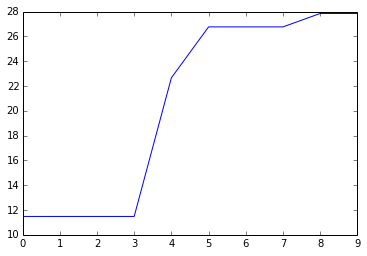

In [9]:
start = time.time()
imp_mcmc(NC_digraph,2)

print time.time() - start

In [ ]:
imp_mcmc(NC_digraph,3)

In [ ]:
imp_mcmc(NC_digraph,4)

In [ ]:
imp_mcmc(NC_digraph,5)

[{'std': 20.169496616177607, 'time': 0.0065119266510009766, 'mean': 11.0625}]
{'std': 12.300878017442498, 'mean': 6.7800000000000002, 'time': 0.029917001724243164}


In [14]:
sc.parallelize(range(0,8),32).getNumPartitions()

32

In [24]:
start = time.time()
rdd = sc.parallelize(range(0,2),2)
x = [random.choice(NC_digraph.nodes())]
spark_greedy.spark_trials(rdd,2**13,x,NC_digraph)
print time.time() - start

7.08270215988


In [25]:
start = time.time()
rdd = sc.parallelize(range(0,4),4)
spark_greedy.spark_trials(rdd,2**12,x,NC_digraph)
print time.time() - start

6.13872289658


In [23]:
main.cascade_trials(2**14,x,NC_digraph)

{'mean': 1.0, 'std': 0.0, 'time': 0.8482577800750732}